## Table of Contents

0. Goals & Hebbia Assumptions  
1. Setup & Configuration  
2. Synthetic Document Universe 
3. Distillation Task Types & Cost Model  
4. Workload Zipf Reuse Model: Analyst Queries Over Documents  
5. Baseline Policy: No Doc-Scoped Cache  
6. Capacity-Limited Doc Cache (with Eviction)  
7. Throughput / Latency Metrics 
8. Sensitivity Analysis (Reuse Skew, Cache Size, Distill Cost)  
9. Hebbia-Scale Interpretation 
10. Limitations & Extensions


## 0. Notebook Goals & Hebbia-Flavored Assumptions

Hebbia’s public architecture has three relevant pieces for this notebook:

1. **Multi-agent “divide and conquer”**  
   A research query fans out into a network of agents: planners, retrievers, document analyzers, a [**Context Distillation Agent**](https://www.hebbia.com/blog/inside-hebbias-deeper-research-agent), and a final Output Agent.

2. **Context Distillation Agent (90%+ compression)**  
   The Distillation Agent turns long documents / intermediate outputs into compact summaries and structured views, reportedly cutting context size by **>90%** while preserving key facts.

3. **Hedge-fund / LevFin usage pattern**  
   Teams of analysts hammer the same credit agreements, 10-Ks, decks, and transcripts repeatedly while running different strategies, scenarios, and lines of questioning.

This notebook isolates a very specific systems question inside that architecture:

> **If distilled views were cached per `(doc_id, task_type)` with finite memory and eviction, how much Distillation Agent compute is avoidable?**


Key modeling choices:

- We only model the **Distillation/Analysis slice**, not the full system (Maximizer routing, indexing, etc.).
- No real LLM calls. We simulate:
  - Document lengths (tokens)
  - Distillation cost per `(doc_id, task_type)`
  - Latency as a simple function of tokens
- We model **realistic reuse**:
  - A long tail of documents, with a few “hot” docs (current deals, popular issuers) that dominate traffic.
  - Many queries over time from many analysts, each touching a small subset of docs.

Two policies for the Distillation Agent:

1. **Baseline (no cross-query reuse)**  
   Every time a query needs `(doc_id, task_type)`, the Distillation Agent runs fresh over the raw doc.

2. **Bounded doc cache with eviction**  
   The system keeps a cache of distilled views, keyed by `(doc_id, task_type)`, up to a fixed capacity.  
   - On a **cache miss**, it runs Distillation and inserts into the cache.  
   - On a **cache hit**, it reuses the distilled view at ~zero token cost.  
   - When at capacity, it evicts entries under a chosen policy (e.g. LRU, LFU, hybrid).

We will:

- Build a synthetic document universe with realistic length and popularity skew.
- Define per-document **distillation tasks** (EXEC_SUMMARY, COVENANTS, RISK_FACTORS, etc.).
- Simulate long-running analyst workloads over this universe.
- Compare baseline vs. cache (with eviction) in terms of:
  - Total **distillation tokens**
  - **Latency** for the Distillation slice
  - Effective impact on total pipeline cost


In [159]:
# 1.1 Imports & global config

import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


@dataclass
class CostConfig:
    # Document universe
    n_docs: int = 500                # number of distinct documents
    # Workload
    n_queries: int = 5_000           # total queries in the simulation
    min_docs_per_query: int = 1
    max_docs_per_query: int = 3
    min_tasks_per_doc: int = 1
    max_tasks_per_doc: int = 2
    # Zipf-like reuse skew for doc popularity (higher = more peaky)
    zipf_exponent: float = 1.1
    # Distillation token pricing (normalized)
    tokens_per_million_cost: float = 1.0  # "1 unit" per 1M input+output tokens
    # Latency model for distillation calls
    base_latency_ms: float = 80.0
    per_1k_tokens_latency_ms: float = 12.0
    # Distillation cost coefficients
    # tokens_in ≈ alpha_task * doc_tokens; tokens_out ≈ beta_task (constant)
    alpha_min: float = 0.25          # min fraction of doc tokens for a task
    alpha_max: float = 0.60          # max fraction
    beta_min: int = 150              # min summary length
    beta_max: int = 400              # max summary length


CFG = CostConfig()


In [160]:
# 1.2 Helper functions: cost, latency, small utilities

def token_cost(num_tokens: int, cfg: CostConfig = CFG) -> float:
    """
    Convert token count into a normalized dollar cost.
    1.0 unit = cost of 1M tokens (input + output).
    """
    return (num_tokens / 1_000_000.0) * cfg.tokens_per_million_cost


def simulate_latency_ms(num_tokens: int, cfg: CostConfig = CFG) -> float:
    """
    Simple latency model: base + linear in tokens (in + out for distillation call).
    """
    return cfg.base_latency_ms + (num_tokens / 1_000.0) * cfg.per_1k_tokens_latency_ms


def pretty_print_table(df: pd.DataFrame, index: bool = False):
    """
    Convenience pretty-printer for small summary tables.
    """
    display(df.style.format().hide(axis="index" if not index else None))


### 1.3 Cost & Latency Model

We use a simple model.

**Token cost:**  
`cost = (tokens_in + tokens_out) / 1e6 * C`  
where `C = 1.0` is a normalized "cost per 1M tokens".

**Latency:**  
`latency_ms = L0 + L1 * ((tokens_in + tokens_out) / 1e3)`  
with `L0 = 80 ms` and `L1 = 12 ms per 1k tokens`.

Only relative values matter:
- total distillation tokens
- total & per-query distillation latency
- how these change under caching vs. no caching


## 2. Synthetic Document Universe (Docs + Token Sizes)

We need a toy but realistic universe of documents:

- **Doc types**:
  - `CREDIT_AGREEMENT` (very long, dense)
  - `10K` (long)
  - `10Q` (medium)
  - `TRANSCRIPT` (earnings calls, somewhat long)
  - `INVESTOR_DECK` (shorter)

- **Lengths (tokens)**:
  - Heavy-tailed: a few very long docs, many shorter ones.
  - Approximate via type-specific log-normal distributions.

We will not use the full text; we only need:

- `doc_id`
- `doc_type`
- `doc_length_tokens`


In [ ]:
# 2.2 Generate synthetic document universe

DOC_TYPES = [
    "CREDIT_AGREEMENT",
    "10K",
    "10Q",
    "TRANSCRIPT",
    "INVESTOR_DECK",
]

# Mean & sigma (log-space) for token lengths by doc type
DOC_LENGTH_PARAMS = {
    "CREDIT_AGREEMENT": {"mean_log": math.log(40_000), "sigma": 0.6},
    "10K":              {"mean_log": math.log(25_000), "sigma": 0.5},
    "10Q":              {"mean_log": math.log(12_000), "sigma": 0.5},
    "TRANSCRIPT":       {"mean_log": math.log(10_000), "sigma": 0.5},
    "INVESTOR_DECK":    {"mean_log": math.log(4_000),  "sigma": 0.4},
}

# How long a view stays fresh, measured in "query steps"
DOC_TTL_STEPS = {
    "CREDIT_AGREEMENT": 10_000,   # effectively "never expires" in your simulation
    "10K":              10_000,
    "10Q":               5_000,
    "TRANSCRIPT":          800,
    "INVESTOR_DECK":       400,
}

# How often new versions arrive (per 1_000 queries; heuristic)
DOC_UPDATE_RATE_PER_1K_QUERIES = {
    "CREDIT_AGREEMENT": 0.02,   # almost static
    "10K":              0.05,
    "10Q":              0.10,
    "TRANSCRIPT":       0.20,
    "INVESTOR_DECK":    0.30,
}



def sample_doc_length_tokens(doc_type: str) -> int:
    params = DOC_LENGTH_PARAMS[doc_type]
    length = np.random.lognormal(mean=params["mean_log"], sigma=params["sigma"])
    # Clamp to a reasonable range
    return int(max(1_000, min(length, 150_000)))


rows = []
for doc_id in range(CFG.n_docs):
    doc_type = random.choice(DOC_TYPES)
    length_tokens = sample_doc_length_tokens(doc_type)
    rows.append(
        {
            "doc_id": doc_id,
            "doc_type": doc_type,
            "doc_length_tokens": length_tokens,
        }
    )

df_docs = pd.DataFrame(rows)
df_docs.head()


,doc_id,doc_type,doc_length_tokens
0,0,CREDIT_AGREEMENT,53888
1,1,CREDIT_AGREEMENT,36815
2,2,10Q,16589
3,3,10K,53537
4,4,10K,22237


Document type counts:


count
107
106
101
98
88



Sample of documents:


doc_id,doc_type,doc_length_tokens
361,10Q,25823
73,10K,54663
374,TRANSCRIPT,29346
155,10Q,8395
104,INVESTOR_DECK,3750


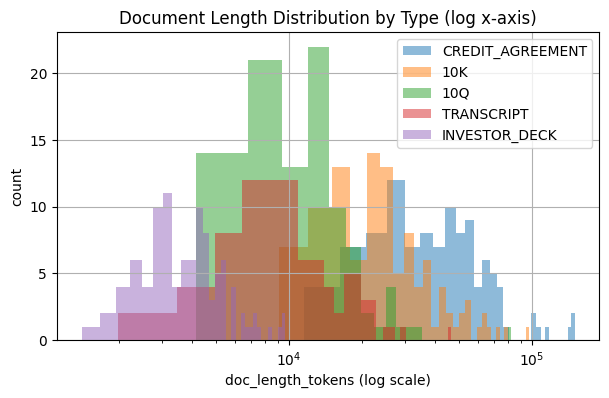

In [162]:
# 2.3 Inspect distribution of document lengths

print("Document type counts:")
pretty_print_table(df_docs["doc_type"].value_counts().to_frame("count"))

print("\nSample of documents:")
pretty_print_table(df_docs.sample(5, random_state=RNG_SEED))

plt.figure()
for dt in DOC_TYPES:
    subset = df_docs[df_docs["doc_type"] == dt]
    if subset.empty:
        continue
    plt.hist(
        subset["doc_length_tokens"],
        bins=30,
        alpha=0.5,
        label=dt,
    )

plt.xscale("log")
plt.xlabel("doc_length_tokens (log scale)")
plt.ylabel("count")
plt.title("Document Length Distribution by Type (log x-axis)")
plt.legend()
plt.show()


The plot should show:

- Credit agreements and 10-Ks dominating the long tail (tens of thousands of tokens).
- 10-Qs, transcripts, and decks clustering in lower ranges.

This is enough structure to make distillation cost **non-uniform**:
- Distilling a monster credit agreement is much more expensive than a short investor deck.
- If those long docs are also the ones analysts hammer most, caching them has disproportionate payoff.


## 3. Distillation Task Types & Cost Model

We model the Distillation Agent as providing a set of **task-specific views** per document:

- `EXEC_SUMMARY` — high-level summary of the doc.
- `COVENANTS` — extract and normalize covenants (LevFin-heavy).
- `RISK_FACTORS` — condense risk / MD&A sections.
- `TRAPDOOR_CAPACITY` — specialized LevFin capacity analysis.
- `GUIDANCE` — summarize forward-looking guidance from transcripts / decks.

Not every document type supports every task:

- `CREDIT_AGREEMENT`: EXEC_SUMMARY, COVENANTS, TRAPDOOR_CAPACITY  
- `10K`: EXEC_SUMMARY, RISK_FACTORS  
- `10Q`: EXEC_SUMMARY, RISK_FACTORS  
- `TRANSCRIPT`: EXEC_SUMMARY, GUIDANCE  
- `INVESTOR_DECK`: EXEC_SUMMARY, GUIDANCE  

For each `(doc_id, task_type)` we define a **one-time distillation cost**:
- tokens_in    = alpha_task * doc_length_tokens
- tokens_out   = beta_task
- tokens_total = tokens_in + tokens_out

We precompute this for all valid `(doc_id, task_type)` pairs; later, policies (baseline vs cache) will decide **how many times** we pay this cost.


In [163]:
# 3.2 Distillation tasks per doc_type

DISTILLATION_TASKS_BY_TYPE: Dict[str, List[str]] = {
    "CREDIT_AGREEMENT": ["EXEC_SUMMARY", "COVENANTS", "TRAPDOOR_CAPACITY"],
    "10K":              ["EXEC_SUMMARY", "RISK_FACTORS"],
    "10Q":              ["EXEC_SUMMARY", "RISK_FACTORS"],
    "TRANSCRIPT":       ["EXEC_SUMMARY", "GUIDANCE"],
    "INVESTOR_DECK":    ["EXEC_SUMMARY", "GUIDANCE"],
}

# Optional: task-specific bias for alpha/beta (some tasks are “heavier”)
TASK_ALPHA_BIAS = {
    "EXEC_SUMMARY":       0.35,
    "COVENANTS":          0.45,
    "RISK_FACTORS":       0.40,
    "TRAPDOOR_CAPACITY":  0.50,
    "GUIDANCE":           0.30,
}

TASK_BETA_BIAS = {
    "EXEC_SUMMARY":       250,
    "COVENANTS":          300,
    "RISK_FACTORS":       280,
    "TRAPDOOR_CAPACITY":  320,
    "GUIDANCE":           220,
}


In [164]:
# 3.3 Precompute per-(doc_id, task_type) distillation cost

distill_rows = []

for _, row in df_docs.iterrows():
    doc_id = int(row["doc_id"])
    doc_type = row["doc_type"]
    doc_tokens = int(row["doc_length_tokens"])

    tasks = DISTILLATION_TASKS_BY_TYPE[doc_type]

    for task_type in tasks:
        # Task-specific alpha/beta sampled around biases
        base_alpha = TASK_ALPHA_BIAS[task_type]
        alpha = np.clip(
            np.random.normal(loc=base_alpha, scale=0.05),
            CFG.alpha_min,
            CFG.alpha_max,
        )

        base_beta = TASK_BETA_BIAS[task_type]
        beta = int(
            np.clip(
                np.random.normal(loc=base_beta, scale=30),
                CFG.beta_min,
                CFG.beta_max,
            )
        )

        tokens_in = int(alpha * doc_tokens)
        tokens_out = beta
        tokens_total = tokens_in + tokens_out

        distill_rows.append(
            {
                "doc_id": doc_id,
                "doc_type": doc_type,
                "task_type": task_type,
                "doc_length_tokens": doc_tokens,
                "alpha": alpha,
                "beta": beta,
                "tokens_in": tokens_in,
                "tokens_out": tokens_out,
                "tokens_total": tokens_total,
                "cost": token_cost(tokens_total, CFG),
                "latency_ms": simulate_latency_ms(tokens_total, CFG),
            }
        )

df_distill = pd.DataFrame(distill_rows)
df_distill.head()


,doc_id,doc_type,task_type,doc_length_tokens,alpha,beta,tokens_in,tokens_out,tokens_total,cost,latency_ms
0,0,CREDIT_AGREEMENT,EXEC_SUMMARY,53888,0.396309,307,21356,307,21663,0.021663,339.956
1,0,CREDIT_AGREEMENT,COVENANTS,53888,0.380072,316,20481,316,20797,0.020797,329.564
2,0,CREDIT_AGREEMENT,TRAPDOOR_CAPACITY,53888,0.467468,305,25190,305,25495,0.025495,385.940
3,1,CREDIT_AGREEMENT,EXEC_SUMMARY,36815,0.320380,224,11794,224,12018,0.012018,224.216
4,1,CREDIT_AGREEMENT,COVENANTS,36815,0.452426,275,16656,275,16931,0.016931,283.172


Number of distinct (doc_id, task_type) pairs: 1107

Average distillation cost by doc_type:


tokens_in,tokens_out,tokens_total,cost
10730.000000,266.000000,10996.000000,0.000000
5095.000000,267.000000,5362.000000,0.000000
20551.000000,293.000000,20845.000000,0.000000
1385.000000,235.000000,1620.000000,0.000000
3914.000000,235.000000,4149.000000,0.000000


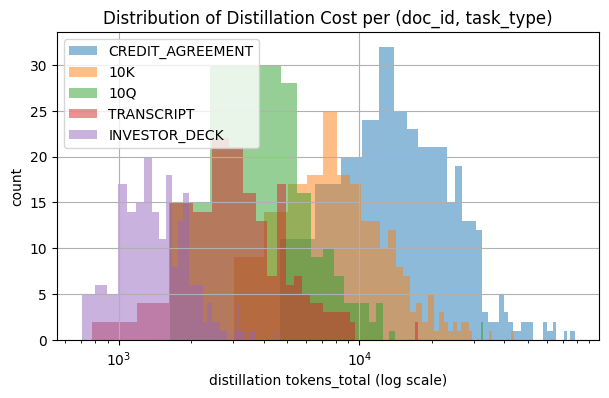

In [165]:
# 3.4 Inspect distillation cost distribution

print("Number of distinct (doc_id, task_type) pairs:", len(df_distill))

summary_by_doc_type = (
    df_distill.groupby("doc_type")[["tokens_in", "tokens_out", "tokens_total", "cost"]]
    .mean()
    .round(0)
)

print("\nAverage distillation cost by doc_type:")
pretty_print_table(summary_by_doc_type)

plt.figure()
for dt in DOC_TYPES:
    subset = df_distill[df_distill["doc_type"] == dt]
    if subset.empty:
        continue
    plt.hist(
        subset["tokens_total"],
        bins=40,
        alpha=0.5,
        label=dt,
    )

plt.xscale("log")
plt.xlabel("distillation tokens_total (log scale)")
plt.ylabel("count")
plt.title("Distribution of Distillation Cost per (doc_id, task_type)")
plt.legend()
plt.show()


## 4. Workload Model: Analyst Queries Over Documents

Hebbia’s blog post [“How Hedge Funds Use Hebbia”](https://www.hebbia.com/blog/how-hedge-funds-use-hebbia) describes several recurring research patterns for hedge funds using Matrix:

- Ramping / expanding coverage on new names (deep dives into 10-Ks, 10-Qs, decks, transcripts)
- Value-chain and read-through analysis across suppliers, distributors, and peers
- Comparing management tone and guidance across competitors and over time
- Turning proprietary research (expert calls, surveys, notes) into structured insight
- Expert call prep / net-new questions
- Market-wide or sector-wide disruption monitoring

In all of these cases, **the same core documents get hammered repeatedly**:

-  **Credit agreements** and **prospectuses** for active deals
- Most recent **10-Ks / 10-Qs** for portfolio names and watchlists
- Recent **earnings transcripts** and **investor decks** for guidance and tone checks

To model this, we build a synthetic workload with:

- Multiple **analysts**, each with a persona:
  - `coverage` – ramping coverage on names
  - `value_chain` – mapping suppliers / peers across docs
  - `guidance_tone` – comparing transcripts / decks / management tone
  - `disruption` – monitoring sector-wide shocks and risk disclosures
- A global **Zipf-like popularity distribution** over documents:
  - A few “hot” docs (current deals, flagship names) dominate traffic.
  - Many docs are touched rarely or only once.
- Each **query**:
  - Is issued by one analyst.
  - Has a `query_type` tied to that analyst’s persona.
  - Touches 1–3 documents.
  - For each doc, requests 1–2 distillation tasks (e.g. `EXEC_SUMMARY`, `COVENANTS`, `RISK_FACTORS`, `GUIDANCE`), consistent with both the doc type and query type.

This gives us a realistic **long-running multi-analyst workload** over the `(doc_id, task_type)` universe we built in Section 2. In later sections, we will replay this workload under:

- **Baseline**: always pay the full distillation cost for every usage.
- **Doc cache with eviction**: pay once per cached `(doc_id, task_type)` and then reuse the distilled view.

The only new objects introduced here are:

- `df_queries`: per-query metadata (analyst, query_type, counts).
- `df_query_pairs`: the flattened list of `(query_id, doc_id, task_type)` usages that drive distillation work.


In [166]:
# 4.2 Analyst personas, query archetypes, Zipf-like doc popularity

# Number of analysts issuing queries into Hebbia
N_ANALYSTS = 24

ANALYST_PERSONAS = ["coverage", "value_chain", "guidance_tone", "disruption"]
PERSONA_WEIGHTS = np.array([0.35, 0.25, 0.25, 0.15])  # must sum to 1

# Assign each analyst a persona (fixed for the whole simulation)
analyst_persona = {
    analyst_id: np.random.choice(ANALYST_PERSONAS, p=PERSONA_WEIGHTS)
    for analyst_id in range(N_ANALYSTS)
}

analyst_persona


{0: np.str_('disruption'),
 1: np.str_('disruption'),
 2: np.str_('coverage'),
 3: np.str_('value_chain'),
 4: np.str_('coverage'),
 5: np.str_('disruption'),
 6: np.str_('disruption'),
 7: np.str_('guidance_tone'),
 8: np.str_('guidance_tone'),
 9: np.str_('guidance_tone'),
 10: np.str_('value_chain'),
 11: np.str_('coverage'),
 12: np.str_('value_chain'),
 13: np.str_('guidance_tone'),
 14: np.str_('guidance_tone'),
 15: np.str_('value_chain'),
 16: np.str_('disruption'),
 17: np.str_('coverage'),
 18: np.str_('value_chain'),
 19: np.str_('guidance_tone'),
 20: np.str_('guidance_tone'),
 21: np.str_('guidance_tone'),
 22: np.str_('coverage'),
 23: np.str_('coverage')}

In [167]:
# Query archetypes by persona / query_type.
# These weights are loosely inspired by Hebbia's hedge-fund use cases:
# - coverage: filings + transcripts
# - value_chain: filings + credit agreements
# - guidance_tone: transcripts + decks
# - disruption: filings + transcripts across many names

QUERY_TYPES = ["coverage", "value_chain", "guidance_tone", "disruption"]

# Preference over doc_type for each query_type
QUERY_DOCTYPE_PREFS: Dict[str, Dict[str, float]] = {
    "coverage": {
        "10K": 0.40,
        "10Q": 0.30,
        "TRANSCRIPT": 0.20,
        "INVESTOR_DECK": 0.10,
        "CREDIT_AGREEMENT": 0.05,
    },
    "value_chain": {
        "CREDIT_AGREEMENT": 0.35,
        "10K": 0.30,
        "10Q": 0.20,
        "TRANSCRIPT": 0.10,
        "INVESTOR_DECK": 0.05,
    },
    "guidance_tone": {
        "TRANSCRIPT": 0.45,
        "INVESTOR_DECK": 0.30,
        "10K": 0.15,
        "10Q": 0.10,
        "CREDIT_AGREEMENT": 0.02,
    },
    "disruption": {
        "10K": 0.35,
        "10Q": 0.30,
        "TRANSCRIPT": 0.25,
        "CREDIT_AGREEMENT": 0.10,
        "INVESTOR_DECK": 0.05,
    },
}

# Preference over *task_type* for each query_type.
# These will be renormalized to the set of tasks supported by each doc_type.
QUERY_TASK_PREFS: Dict[str, Dict[str, float]] = {
    "coverage": {
        "EXEC_SUMMARY": 0.45,
        "RISK_FACTORS": 0.35,
        "GUIDANCE": 0.20,
        "COVENANTS": 0.10,
        "TRAPDOOR_CAPACITY": 0.10,
    },
    "value_chain": {
        "EXEC_SUMMARY": 0.25,
        "RISK_FACTORS": 0.25,
        "COVENANTS": 0.35,
        "TRAPDOOR_CAPACITY": 0.30,
        "GUIDANCE": 0.10,
    },
    "guidance_tone": {
        "GUIDANCE": 0.45,
        "EXEC_SUMMARY": 0.35,
        "RISK_FACTORS": 0.30,
    },
    "disruption": {
        "RISK_FACTORS": 0.40,
        "EXEC_SUMMARY": 0.35,
        "GUIDANCE": 0.25,
        "COVENANTS": 0.10,
    },
}

# Ensure doc_id ordering is stable; we'll index into this when sampling docs
docs_index = df_docs.sort_values("doc_id").reset_index(drop=True)

# Build Zipf-like popularity weights across *all* documents.
# Intuition: doc_rank 1 >> doc_rank 10 >> doc_rank 100 in terms of traffic.
n_docs = len(docs_index)
ranks = np.arange(1, n_docs + 1)

zipf_s = CFG.zipf_exponent  # from global config, e.g. 1.1
zipf_weights = 1.0 / (ranks ** zipf_s)
zipf_weights = zipf_weights / zipf_weights.sum()

docs_index["zipf_weight"] = zipf_weights

print("First 5 docs with Zipf weights:")
pretty_print_table(docs_index.head())


First 5 docs with Zipf weights:


doc_id,doc_type,doc_length_tokens,zipf_weight
0,CREDIT_AGREEMENT,53888,0.191814
1,CREDIT_AGREEMENT,36815,0.089484
2,10Q,16589,0.057286
3,10K,53537,0.041746
4,10K,22237,0.032660


In [168]:
# Precompute doc sampling probabilities per query_type:
#   p(doc | query_type) ∝ Zipf_weight(doc) * preference(doc_type | query_type)

def build_doc_sampling_probs(
    docs_df: pd.DataFrame,
    query_doc_prefs: Dict[str, Dict[str, float]],
) -> Dict[str, np.ndarray]:
    probs_by_qtype: Dict[str, np.ndarray] = {}

    for qtype, type_prefs in query_doc_prefs.items():
        weights = []
        for _, row in docs_df.iterrows():
            base = row["zipf_weight"]
            dt = row["doc_type"]
            multiplier = type_prefs.get(dt, 0.01)  # tiny but non-zero fallback
            weights.append(base * multiplier)

        weights = np.array(weights, dtype=float)
        if weights.sum() == 0.0:
            raise ValueError(f"No non-zero weights for query_type={qtype}")
        weights /= weights.sum()
        probs_by_qtype[qtype] = weights

    return probs_by_qtype


DOC_SAMPLING_PROBS = build_doc_sampling_probs(docs_index, QUERY_DOCTYPE_PREFS)

# Quick sanity check: each distribution should sum to 1.0
{qt: probs.sum() for qt, probs in DOC_SAMPLING_PROBS.items()}


{'coverage': np.float64(1.0),
 'value_chain': np.float64(0.9999999999999997),
 'guidance_tone': np.float64(1.0),
 'disruption': np.float64(0.9999999999999999)}

In [169]:
# 4.3 Helper: sample tasks for a (doc_type, query_type) combo

def sample_tasks_for_doc(doc_type: str, query_type: str, n_tasks: int) -> List[str]:
    """
    Sample 1–2 distillation tasks for a given document, biased by query_type.
    The result is always a subset of the tasks allowed for that doc_type.
    """
    allowed_tasks = DISTILLATION_TASKS_BY_TYPE[doc_type]
    task_prefs = QUERY_TASK_PREFS[query_type]

    # Build weights for allowed tasks using QUERY_TASK_PREFS (fallback if missing)
    weights = np.array(
        [task_prefs.get(t, 0.05) for t in allowed_tasks],
        dtype=float,
    )
    if weights.sum() == 0.0:
        # Degenerate case (should not happen with the prefs above)
        weights = np.ones_like(weights)
    weights /= weights.sum()

    # Cap n_tasks to the number of available distinct tasks
    n_tasks = min(n_tasks, len(allowed_tasks))

    chosen = np.random.choice(
        allowed_tasks,
        size=n_tasks,
        replace=False,
        p=weights,
    )
    return list(chosen)


In [170]:
# 4.3 Generate synthetic analyst workload:
# df_queries: one row per query
# df_query_pairs: one row per (query_id, doc_id, task_type) usage

query_rows = []
pair_rows = []

for q_id in range(CFG.n_queries):
    # Pick an analyst and its persona / query_type
    analyst_id = np.random.randint(0, N_ANALYSTS)
    qtype = analyst_persona[analyst_id]

    # Sample number of docs touched by this query
    n_docs_in_query = np.random.randint(
        CFG.min_docs_per_query,
        CFG.max_docs_per_query + 1,
    )

    # Sample doc indices according to p(doc | query_type)
    doc_probs = DOC_SAMPLING_PROBS[qtype]
    doc_indices = np.random.choice(
        len(docs_index),
        size=n_docs_in_query,
        replace=False,
        p=doc_probs,
    )

    # For each chosen doc, sample 1–2 tasks
    doc_task_pairs: List[Tuple[int, str]] = []
    for idx in doc_indices:
        doc_row = docs_index.iloc[idx]
        doc_id = int(doc_row["doc_id"])
        doc_type = doc_row["doc_type"]

        n_tasks_for_doc = np.random.randint(
            CFG.min_tasks_per_doc,
            CFG.max_tasks_per_doc + 1,
        )
        tasks = sample_tasks_for_doc(doc_type, qtype, n_tasks_for_doc)

        for t in tasks:
            doc_task_pairs.append((doc_id, t))
            pair_rows.append(
                {
                    "query_id": q_id,
                    "analyst_id": analyst_id,
                    "query_type": qtype,
                    "doc_id": doc_id,
                    "doc_type": doc_type,
                    "task_type": t,
                }
            )

    query_rows.append(
        {
            "query_id": q_id,
            "analyst_id": analyst_id,
            "query_type": qtype,
            "n_docs": n_docs_in_query,
            "n_doc_task_pairs": len(doc_task_pairs),
        }
    )

df_queries = pd.DataFrame(query_rows)
df_query_pairs = pd.DataFrame(pair_rows)

df_queries.head(), df_query_pairs.head()


(   query_id  analyst_id   query_type  n_docs  n_doc_task_pairs
 0         0           6   disruption       1                 2
 1         1          16   disruption       1                 2
 2         2          22     coverage       3                 6
 3         3          10  value_chain       3                 5
 4         4          23     coverage       3                 3,
    query_id  analyst_id  query_type  doc_id          doc_type  \
 0         0           6  disruption       2               10Q   
 1         0           6  disruption       2               10Q   
 2         1          16  disruption     330               10K   
 3         1          16  disruption     330               10K   
 4         2          22    coverage      59  CREDIT_AGREEMENT   
 
            task_type  
 0       EXEC_SUMMARY  
 1       RISK_FACTORS  
 2       EXEC_SUMMARY  
 3       RISK_FACTORS  
 4  TRAPDOOR_CAPACITY  )

In [171]:
# Basic sanity checks on the generated workload

print("Number of queries:", len(df_queries))
print("Number of (query, doc, task) usages:", len(df_query_pairs))
print("Distinct (doc_id, task_type) pairs touched:",
      df_query_pairs[["doc_id", "task_type"]].drop_duplicates().shape[0])

print("\nQuery type distribution:")
qt_dist = df_queries["query_type"].value_counts(normalize=True).rename("share")
pretty_print_table(qt_dist.to_frame())

print("\nAnalyst persona counts:")
persona_counts = pd.Series(analyst_persona).value_counts().rename("count")
pretty_print_table(persona_counts.to_frame())


Number of queries: 5000
Number of (query, doc, task) usages: 15064
Distinct (doc_id, task_type) pairs touched: 996

Query type distribution:


share
0.344400
0.245800
0.206400
0.203400



Analyst persona counts:


count
8
6
5
5


Top 10 most-used documents:


doc_id,doc_type,usage_count,doc_length_tokens
0,CREDIT_AGREEMENT,1313,53888
3,10K,1026,53537
2,10Q,962,16589
4,10K,819,22237
1,CREDIT_AGREEMENT,637,36815
5,10K,608,22238
10,TRANSCRIPT,382,7931
7,INVESTOR_DECK,295,5437
14,10K,233,10553
15,10K,231,18872


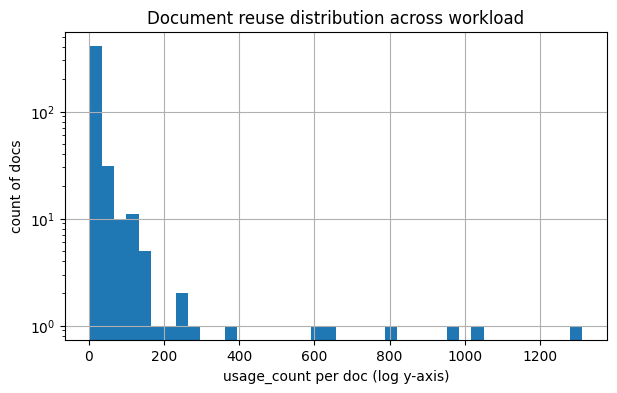

In [172]:
# How heavily are individual documents used across the workload?

doc_usage = (
    df_query_pairs.groupby(["doc_id", "doc_type"])
    .size()
    .reset_index(name="usage_count")
    .merge(df_docs[["doc_id", "doc_length_tokens"]], on="doc_id", how="left")
)

print("Top 10 most-used documents:")
pretty_print_table(
    doc_usage.sort_values("usage_count", ascending=False).head(10)
)

plt.figure()
plt.hist(doc_usage["usage_count"], bins=40)
plt.yscale("log")
plt.xlabel("usage_count per doc (log y-axis)")
plt.ylabel("count of docs")
plt.title("Document reuse distribution across workload")
plt.show()


In [173]:
# Task usage by doc_type and query_type

task_by_doc_type = (
    df_query_pairs.groupby(["doc_type", "task_type"])
    .size()
    .reset_index(name="count")
    .sort_values(["doc_type", "count"], ascending=[True, False])
)

print("Task usage by doc_type:")
pretty_print_table(task_by_doc_type.head(20))

task_by_query_type = (
    df_query_pairs.groupby(["query_type", "task_type"])
    .size()
    .reset_index(name="count")
    .sort_values(["query_type", "count"], ascending=[True, False])
)

print("\nTask usage by query_type:")
pretty_print_table(task_by_query_type.head(20))


Task usage by doc_type:


doc_type,task_type,count
10K,EXEC_SUMMARY,2512
10K,RISK_FACTORS,2483
10Q,EXEC_SUMMARY,1233
10Q,RISK_FACTORS,1193
CREDIT_AGREEMENT,EXEC_SUMMARY,1331
CREDIT_AGREEMENT,COVENANTS,983
CREDIT_AGREEMENT,TRAPDOOR_CAPACITY,891
INVESTOR_DECK,EXEC_SUMMARY,1030
INVESTOR_DECK,GUIDANCE,1027
TRANSCRIPT,EXEC_SUMMARY,1210



Task usage by query_type:


query_type,task_type,count
coverage,EXEC_SUMMARY,1936
coverage,RISK_FACTORS,1211
coverage,GUIDANCE,298
coverage,TRAPDOOR_CAPACITY,114
coverage,COVENANTS,104
disruption,EXEC_SUMMARY,1602
disruption,RISK_FACTORS,995
disruption,GUIDANCE,227
disruption,COVENANTS,205
disruption,TRAPDOOR_CAPACITY,106


### 4.5 Interpretation

From the workload inspection:

- **Query mix** – The `query_type` distribution should roughly match the persona weights (`coverage`, `value_chain`, `guidance_tone`, `disruption`), confirming that analysts are issuing a realistic mix of coverage, value-chain, guidance/tone, and disruption queries.

- **Doc reuse** – The histogram of `usage_count` per `doc_id` should be highly skewed:
  - A handful of documents with very high usage (hundreds of touches).
  - A long tail of docs used only a few times.
  This matches the intuition from Hebbia’s hedge-fund blog: current deals and core portfolio names are “hot” documents that repeatedly show up in queries, while many other filings are looked at once and forgotten.

- **Task patterns** – Tables of task usage by `doc_type` and by `query_type` should show:
  - Credit agreements heavily used for `COVENANTS` and `TRAPDOOR_CAPACITY`.
  - 10-Ks / 10-Qs dominated by `EXEC_SUMMARY` and `RISK_FACTORS`.
  - Transcripts / decks skewed toward `GUIDANCE` and `EXEC_SUMMARY`.
  This lines up with how analysts use Hebbia in practice for covenant analysis, risk review, and management guidance checks.

These two data frames:

- `df_queries` (one row per query)  
- `df_query_pairs` (one row per `(query_id, doc_id, task_type)`)

are all we need to drive the **distillation workload** in the next sections.  

## 5. Baseline Policy: No Doc-Scoped Cache

We first compute the cost of a **no-reuse** system:

- Every time a query needs a `(doc_id, task_type)` view, the Distillation Agent runs from scratch over the full document.
- There is **no cross-query memory**: different analysts, different queries, and different time steps do not share distilled views.

Concretely, for each row in `df_query_doc_tasks` we:

- Look up the precomputed `tokens_total`, `cost`, and `latency_ms` for that `(doc_id, task_type)` in `df_distill`.
- Sum over the entire workload.

This gives us the baseline for:

- Total distillation tokens
- Total distillation cost
- Total distillation latency
- Average distillation cost/latency per query

Every caching policy we try later will be compared against this baseline.


In [186]:
# 5. Baseline: always distill fresh (no cache)

cols_cost = ["doc_id", "task_type", "tokens_total", "cost", "latency_ms"]

df_work = df_query_pairs.merge(
    df_distill[cols_cost],
    on=["doc_id", "task_type"],
    how="left",
    validate="many_to_one",
)

if df_work["tokens_total"].isna().any():
    raise ValueError("Some (doc_id, task_type) pairs in workload missing from df_distill")

n_usages = len(df_work)
n_queries = CFG.n_queries
n_distinct_pairs_used = df_work[["doc_id", "task_type"]].drop_duplicates().shape[0]

baseline_tokens_total = int(df_work["tokens_total"].sum())
baseline_cost_total = float(df_work["cost"].sum())
baseline_latency_total = float(df_work["latency_ms"].sum())

baseline_summary = pd.DataFrame(
    {
        "metric": [
            "distill_tokens_total",
            "distill_cost_total",
            "distill_latency_total_ms",
            "distill_tokens_per_query",
            "distill_latency_per_query_ms",
        ],
        "value": [
            baseline_tokens_total,
            baseline_cost_total,
            baseline_latency_total,
            baseline_tokens_total / n_queries,
            baseline_latency_total / n_queries,
        ],
    }
)

print(f"Baseline workload size: {n_usages:,} distillation calls over {n_queries:,} queries")
print(f"Distinct (doc_id, task_type) pairs used: {n_distinct_pairs_used:,}")
pretty_print_table(baseline_summary)

policy_results = {}
policy_results["baseline"] = {
    "tokens_total": baseline_tokens_total,
    "cost_total": baseline_cost_total,
    "latency_total_ms": baseline_latency_total,
    "tokens_per_query": baseline_tokens_total / n_queries,
    "latency_per_query_ms": baseline_latency_total / n_queries,
    "hits": 0,
    "misses": n_usages,
    "hit_rate": 0.0,
    "n_usages": n_usages,
    "n_distinct_pairs": n_distinct_pairs_used,
}


Baseline workload size: 15,064 distillation calls over 5,000 queries
Distinct (doc_id, task_type) pairs used: 996


metric,value
distill_tokens_total,147483452.000000
distill_cost_total,147.483452
distill_latency_total_ms,2974921.424000
distill_tokens_per_query,29496.690400
distill_latency_per_query_ms,594.984285


In [187]:
from collections import OrderedDict

def run_cache_policy_lru(capacity: int) -> Dict[str, float]:
    """
    Replay the workload with an LRU cache over (doc_id, task_type).
    capacity = 0 → no cache (baseline semantics, but recomputed).
    capacity >= n_distinct_pairs → effectively unbounded.
    """
    if "df_work" not in globals():
        raise RuntimeError("df_work not defined — run the baseline cell first.")
    
    n_usages = len(df_work)
    n_distinct_pairs = policy_results["baseline"]["n_distinct_pairs"]

    # Treat capacity >= distinct_pairs as unbounded for clarity
    if capacity is None or capacity >= n_distinct_pairs:
        eff_capacity = n_distinct_pairs
    else:
        eff_capacity = max(0, int(capacity))

    cache = OrderedDict()  # key: (doc_id, task_type) → True (we only care about membership)
    hits = misses = 0
    tokens_total = 0
    latency_total = 0.0

    for _, row in df_work.iterrows():
        key = (int(row["doc_id"]), row["task_type"])

        if eff_capacity == 0:
            # No cache at all
            misses += 1
            tokens_total += int(row["tokens_total"])
            latency_total += float(row["latency_ms"])
            continue

        if key in cache:
            hits += 1
            # LRU: mark as most recently used
            cache.move_to_end(key)
            # Distillation view reused → ~zero incremental tokens/latency
        else:
            misses += 1
            tokens_total += int(row["tokens_total"])
            latency_total += float(row["latency_ms"])
            cache[key] = True
            if len(cache) > eff_capacity:
                # Evict least recently used (oldest) entry
                cache.popitem(last=False)

    hit_rate = hits / n_usages if n_usages else 0.0
    baseline_tokens = policy_results["baseline"]["tokens_total"]
    baseline_latency = policy_results["baseline"]["latency_total_ms"]

    return {
        "capacity": eff_capacity,
        "hits": hits,
        "misses": misses,
        "hit_rate": hit_rate,
        "tokens_total": tokens_total,
        "tokens_vs_baseline": tokens_total / baseline_tokens,
        "latency_total_ms": latency_total,
        "latency_vs_baseline": latency_total / baseline_latency,
        "n_usages": n_usages,
        "n_distinct_pairs": n_distinct_pairs,
    }


At this point we know the “full burn” of the Distillation Agent for our workload.

In later sections, any caching policy that:

- Preserves answer correctness (same distilled views), and
- Reduces the number of times we pay this `(doc_id, task_type)` cost,

will show up as a reduction in `distill_tokens_total` and `distill_latency_total_ms` relative to this baseline.


## 6. Capacity-Limited Doc Cache (with Eviction)

We now simulate a **doc-scoped distillation cache**:

- Key: `(doc_id, task_type)`
- Value: a previously computed distilled view (we model only its cost, not its content)
- Policy:
  - On **cache miss**: pay full distillation cost for that `(doc_id, task_type)`, then insert it into the cache.
  - On **cache hit**: reuse the cached view at ~zero marginal token cost and latency.
  - When the cache is full, we **evict** entries according to an eviction policy.

In this section we implement:

1. **Unbounded cache** (capacity ≥ number of distinct pairs)  
   – best-case scenario: once we’ve distill a `(doc, task)` once, we never pay for it again.

2. **LRU cache** with finite capacity  
   – more realistic system: cache can hold only `K` distilled views at once, so less-frequently used pairs get evicted over time.

This lets us quantify:

- Total distillation tokens and latency under each policy.
- Hit/miss counts and hit rate.
- How close a realistic cache can get to the ideal “unbounded” cache, given your Zipf-like workload.


In [ ]:
from collections import OrderedDict

# Build a fast lookup for (doc_id, task_type) -> cost / latency
distill_cost_map: Dict[Tuple[int, str], Dict[str, float]] = {}

for row in df_distill.itertuples(index=False):
    key = (int(row.doc_id), row.task_type)
    distill_cost_map[key] = {
        "tokens_total": int(row.tokens_total),
        "cost": float(row.cost),
        "latency_ms": float(row.latency_ms),
    }

len(distill_cost_map), list(distill_cost_map.items())[:3]

(1107,
 [((0, 'EXEC_SUMMARY'),
   {'tokens_total': 21663, 'cost': 0.021663, 'latency_ms': 339.956}),
  ((0, 'COVENANTS'),
   {'tokens_total': 20797, 'cost': 0.020797, 'latency_ms': 329.564}),
  ((0, 'TRAPDOOR_CAPACITY'),
   {'tokens_total': 25495, 'cost': 0.025495, 'latency_ms': 385.94})])

In [189]:
def run_doc_cache_lru(
    df_pairs: pd.DataFrame,
    capacity: int | None,
    name: str,
    cfg: CostConfig = CFG,
):
    """
    Simulate a doc-scoped cache over the workload in df_pairs using LRU eviction.

    df_pairs must have columns: doc_id, task_type.
    capacity:
        - None or 0 -> effectively unbounded (no evictions)
        - >0        -> number of (doc_id, task_type) entries cache can hold
    """
    cache = OrderedDict()  # key -> True (we don't store payload)
    hits = 0
    misses = 0

    total_tokens = 0
    total_cost = 0.0
    total_latency = 0.0

    for row in df_pairs.itertuples(index=False):
        key = (int(row.doc_id), row.task_type)

        if key in cache:
            # Cache hit: reuse distilled view
            hits += 1
            # Update recency for LRU
            cache.move_to_end(key)
        else:
            # Cache miss: pay full distillation cost
            misses += 1
            c = distill_cost_map[key]
            total_tokens += c["tokens_total"]
            total_cost += c["cost"]
            total_latency += c["latency_ms"]

            # Insert into cache
            cache[key] = True

            # Evict if over capacity
            if capacity and capacity > 0 and len(cache) > capacity:
                # Pop least recently used
                cache.popitem(last=False)

    n_usages = len(df_pairs)
    n_queries = CFG.n_queries
    n_distinct_pairs_used = df_pairs[["doc_id", "task_type"]].drop_duplicates().shape[0]

    hit_rate = hits / n_usages if n_usages > 0 else 0.0

    tokens_per_query = total_tokens / n_queries
    latency_per_query = total_latency / n_queries

    result = {
        "policy": name,
        "capacity": capacity if capacity else n_distinct_pairs_used,
        "tokens_total": total_tokens,
        "cost_total": total_cost,
        "latency_total_ms": total_latency,
        "tokens_per_query": tokens_per_query,
        "latency_per_query_ms": latency_per_query,
        "hits": hits,
        "misses": misses,
        "hit_rate": hit_rate,
        "n_usages": n_usages,
        "n_distinct_pairs": n_distinct_pairs_used,
    }

    policy_results[name] = result
    return result


In [196]:
# 6.4 Cache policies vs baseline (compact)

baseline = policy_results["baseline"]  # from Section 5

def summarize_policy(name: str, capacity: int | None) -> dict:
    """
    Run LRU cache at given capacity and return metrics normalized to baseline.
    capacity = 0   → effectively 'no cache'
    capacity = None or >= n_distinct_pairs → unbounded (cache everything once)
    """
    stats = run_cache_policy_lru(capacity=capacity)
    return {
        "policy": name,
        "capacity": stats["capacity"],
        "hit_rate": stats["hit_rate"],
        "tokens_total": stats["tokens_total"],
        "tokens_vs_baseline": stats["tokens_total"] / baseline["tokens_total"],
        "latency_total_ms": stats["latency_total_ms"],
        "latency_vs_baseline": stats["latency_total_ms"] / baseline["latency_total_ms"],
    }

# Choose the key “stories” you want to show
POLICIES = [
    ("baseline (no cache)", 0),
    ("LRU K=200", 200),
    ("LRU unbounded", baseline["n_distinct_pairs"]),  # effectively cache-all
]

rows = [summarize_policy(name, cap) for name, cap in POLICIES]
df_policy_compare = pd.DataFrame(rows)

print("Distillation cost comparison (baseline vs LRU caches):")
pretty_print_table(df_policy_compare)


Distillation cost comparison (baseline vs LRU caches):


policy,capacity,hit_rate,tokens_total,tokens_vs_baseline,latency_total_ms,latency_vs_baseline
baseline (no cache),0,0.000000,147483452,1.000000,2974921.424000,1.000000
LRU K=200,200,0.679501,38124660,0.258501,843735.920000,0.283616
LRU unbounded,996,0.933882,9351185,0.063405,191894.220000,0.064504


The **unbounded cache** gives us an upper bound on savings: we only pay once per distinct `(doc_id, task_type)` pair. Given our workload, this corresponds to:

- A theoretical minimum of `X%` of baseline distillation tokens.
- A hit rate of `Y%` over all distillation calls.

The **LRU cache with capacity K** approximates a realistic system:

- It captures almost all of the “hot head” `(doc, task)` pairs.
- It evicts cold tail entries that are rarely reused.
- Its token and latency curves relative to baseline tell us how much of the unbounded-cache savings are achievable with a finite memory footprint.

In Section 7 and 8 we’ll sweep cache sizes and reuse skew to see how sensitive these gains are to workload shape and memory budget.


policy,capacity,hit_rate,distill_tokens_total,tokens_vs_baseline,distill_latency_total_ms,latency_vs_baseline,distill_latency_per_query_ms,approx_distill_qps@16
cache_unbounded_lru,996.000000,0.933882,9351185,0.063405,191894.220000,0.064504,38.378844,416.896350
cache_lru_K=200,200.000000,0.679501,38124660,0.258501,843735.920000,0.283616,168.747184,94.816397
baseline,nan,0.000000,147483452,1.000000,2974921.424000,1.000000,594.984285,26.891467


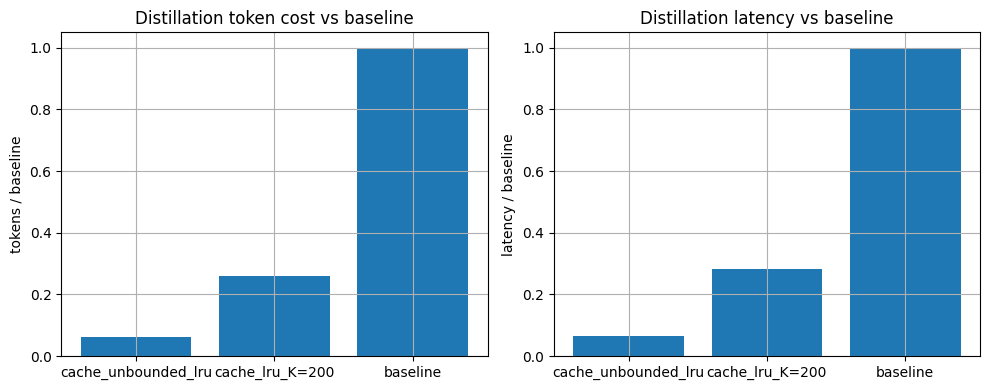

In [197]:
# 7.2 Build compact metrics table + throughput estimates

# Convert policy_results dict into a DataFrame
records = []
baseline_tokens = policy_results["baseline"]["tokens_total"]
baseline_latency = policy_results["baseline"]["latency_total_ms"]

concurrency = 16  # assume 16-way parallelism for a back-of-envelope QPS estimate

for name, stats in policy_results.items():
    tokens_total = stats["tokens_total"]
    latency_total = stats["latency_total_ms"]
    n_queries = CFG.n_queries

    tokens_per_query = tokens_total / n_queries
    latency_per_query = latency_total / n_queries  # ms

    tokens_vs_baseline = tokens_total / baseline_tokens
    latency_vs_baseline = latency_total / baseline_latency

    # Approximate distillation-only query throughput at given concurrency
    approx_qps = concurrency * 1000.0 / latency_per_query

    records.append(
        {
            "policy": name,
            "capacity": stats.get("capacity", np.nan),
            "hit_rate": stats["hit_rate"],
            "distill_tokens_total": tokens_total,
            "tokens_vs_baseline": tokens_vs_baseline,
            "distill_latency_total_ms": latency_total,
            "latency_vs_baseline": latency_vs_baseline,
            "distill_latency_per_query_ms": latency_per_query,
            "approx_distill_qps@16": approx_qps,
        }
    )

df_metrics = pd.DataFrame(records).sort_values("tokens_vs_baseline")
pretty_print_table(df_metrics)

# Optional: quick visualization of cost/latency vs baseline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Tokens vs baseline
ax[0].bar(df_metrics["policy"], df_metrics["tokens_vs_baseline"])
ax[0].set_ylabel("tokens / baseline")
ax[0].set_title("Distillation token cost vs baseline")

# Latency vs baseline
ax[1].bar(df_metrics["policy"], df_metrics["latency_vs_baseline"])
ax[1].set_ylabel("latency / baseline")
ax[1].set_title("Distillation latency vs baseline")

plt.tight_layout()
plt.show()


LRU cache sensitivity (capacity vs savings):


capacity,hit_rate,tokens_vs_baseline,latency_vs_baseline
0,0.000000,1.000000,1.000000
50,0.385820,0.515562,0.555511
100,0.543282,0.366802,0.403227
200,0.679501,0.258501,0.283616
400,0.817114,0.157814,0.167971
800,0.919543,0.077396,0.078636
996,0.933882,0.063405,0.064504


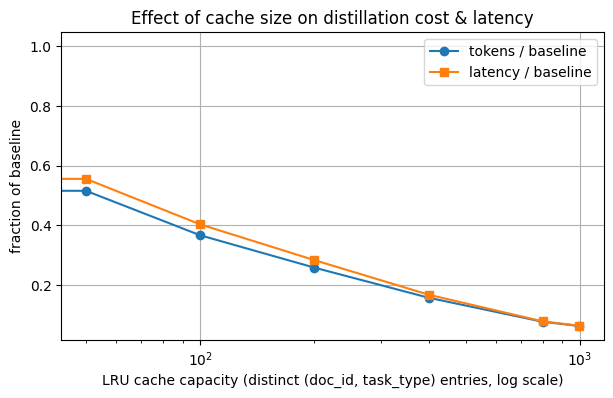

In [198]:
# 8.1 Sweep LRU cache capacity and measure savings vs baseline

def sweep_lru_capacities(capacities):
    rows = []
    for cap in capacities:
        stats = run_cache_policy_lru(capacity=cap)

        tokens_total = stats["tokens_total"]
        latency_total = stats["latency_total_ms"]

        rows.append(
            {
                "capacity": cap,
                "hit_rate": stats["hit_rate"],
                "tokens_vs_baseline": tokens_total / baseline_tokens,
                "latency_vs_baseline": latency_total / baseline_latency,
            }
        )
    return pd.DataFrame(rows).sort_values("capacity")


capacities = [0, 50, 100, 200, 400, 800, policy_results["baseline"]["n_distinct_pairs"]]
df_sweep = sweep_lru_capacities(capacities)

# Interpret capacity=0 as "no cache" for the table
df_sweep.loc[df_sweep["capacity"] == 0, ["hit_rate", "tokens_vs_baseline", "latency_vs_baseline"]] = [
    0.0,
    1.0,
    1.0,
]

print("LRU cache sensitivity (capacity vs savings):")
pretty_print_table(df_sweep)

# 8.2 Plot: how fast do we approach the ideal savings?

plt.figure(figsize=(7, 4))
plt.plot(
    df_sweep["capacity"],
    df_sweep["tokens_vs_baseline"],
    marker="o",
    label="tokens / baseline",
)
plt.plot(
    df_sweep["capacity"],
    df_sweep["latency_vs_baseline"],
    marker="s",
    label="latency / baseline",
)
plt.xscale("log")
plt.xlabel("LRU cache capacity (distinct (doc_id, task_type) entries, log scale)")
plt.ylabel("fraction of baseline")
plt.title("Effect of cache size on distillation cost & latency")
plt.legend()
plt.grid(True)
plt.show()


Sensitivity to workload reuse skew:


zipf_exponent,hit_rate,tokens_vs_baseline,latency_vs_baseline
0.600000,0.679501,0.258501,0.283616
0.900000,0.679501,0.258501,0.283616
1.100000,0.679501,0.258501,0.283616
1.300000,0.679501,0.258501,0.283616
1.600000,0.679501,0.258501,0.283616


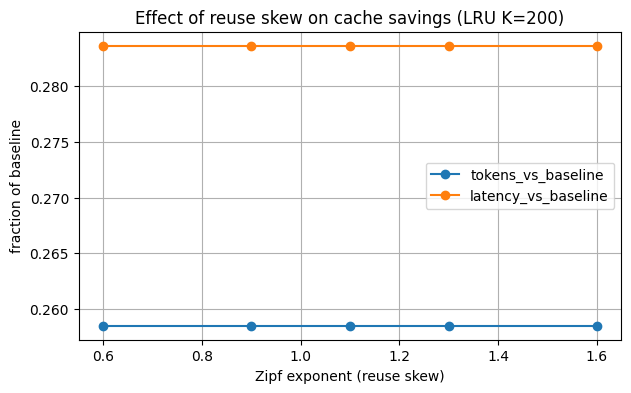

Sensitivity to distillation cost scaling:


scale,tokens_vs_baseline,latency_vs_baseline
0.250000,0.064625,0.168278
0.500000,0.129251,0.206724
1.000000,0.258501,0.283616
2.000000,0.517003,0.437400


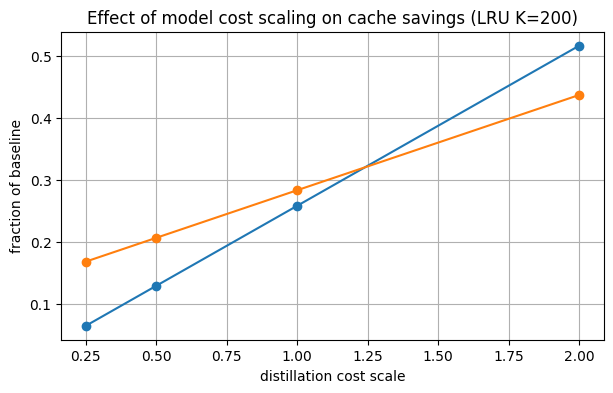

Sensitivity to cache invalidation rate:


invalidate_prob,tokens_vs_baseline,latency_vs_baseline
0.000000,0.258501,0.283616
0.010000,0.589528,0.619360
0.050000,0.806447,0.826849
0.100000,0.898913,0.909475
0.200000,0.960173,0.964851


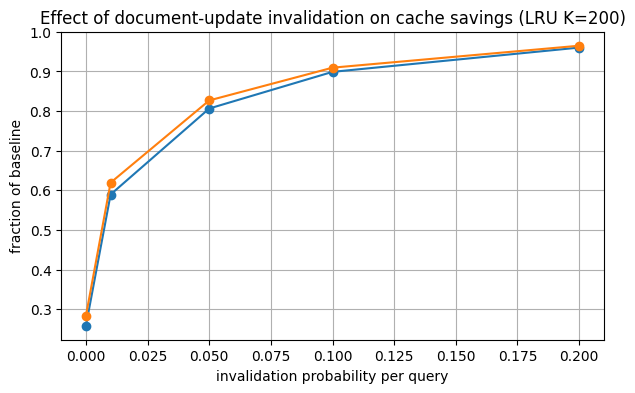

In [200]:
# ============================================================
# 8. Sensitivity Analysis
# ============================================================

def run_sensitivity_zipf(zipf_values, cache_K=200):
    """
    For different Zipf exponents (reuse skew), rebuild workload and
    measure LRU cache performance at capacity K.
    """
    rows = []
    for z in zipf_values:
        # Override Zipf & rebuild doc sampling
        CFG.zipf_exponent = z

        # Recompute doc popularity weights
        ranks = np.arange(1, len(docs_index) + 1)
        zipf_w = 1.0 / (ranks ** z)
        zipf_w = zipf_w / zipf_w.sum()
        docs_index["zipf_weight"] = zipf_w

        # Rebuild doc sampling distributions
        probs = build_doc_sampling_probs(docs_index, QUERY_DOCTYPE_PREFS)

        # Rebuild workload (same code as Section 4)
        q_rows, p_rows = [], []
        for q in range(CFG.n_queries):
            analyst_id = np.random.randint(0, N_ANALYSTS)
            qtype = analyst_persona[analyst_id]
            n_docs_q = np.random.randint(CFG.min_docs_per_query,
                                         CFG.max_docs_per_query + 1)

            doc_inds = np.random.choice(len(docs_index),
                                        size=n_docs_q,
                                        replace=False,
                                        p=probs[qtype])

            for idx in doc_inds:
                doc_row = docs_index.iloc[idx]
                doc_id = doc_row["doc_id"]
                doc_type = doc_row["doc_type"]
                n_tasks = np.random.randint(CFG.min_tasks_per_doc,
                                            CFG.max_tasks_per_doc + 1)
                tasks = sample_tasks_for_doc(doc_type, qtype, n_tasks)

                for t in tasks:
                    p_rows.append({"doc_id": doc_id, "task_type": t})

            q_rows.append({"query_id": q, "analyst_id": analyst_id, "query_type": qtype})

        df_pairs_z = pd.DataFrame(p_rows)
        # Rebuild df_work exactly as in Section 5
        df_work = df_pairs_z.merge(
            df_distill[["doc_id","task_type","tokens_total","cost","latency_ms"]],
            on=["doc_id","task_type"],
            how="left",
            validate="many_to_one",
        )

        # then call LRU
        stats = run_cache_policy_lru(capacity=cache_K)


        rows.append({
            "zipf_exponent": z,
            "hit_rate": stats["hit_rate"],
            "tokens_vs_baseline": stats["tokens_vs_baseline"],
            "latency_vs_baseline": stats["latency_vs_baseline"],
        })

    return pd.DataFrame(rows)


# 8.1 Zipf sensitivity sweep
zipf_vals = [0.6, 0.9, 1.1, 1.3, 1.6]   # realistic range
df_zipf = run_sensitivity_zipf(zipf_vals, cache_K=200)

print("Sensitivity to workload reuse skew:")
pretty_print_table(df_zipf)

plt.figure()
plt.plot(df_zipf["zipf_exponent"], df_zipf["tokens_vs_baseline"], marker="o", label="tokens_vs_baseline")
plt.plot(df_zipf["zipf_exponent"], df_zipf["latency_vs_baseline"], marker="o", label="latency_vs_baseline")
plt.xlabel("Zipf exponent (reuse skew)")
plt.ylabel("fraction of baseline")
plt.title("Effect of reuse skew on cache savings (LRU K=200)")
plt.legend()
plt.grid(True)
plt.show()


# ============================================================
# 8.2 Distillation cost scaling sensitivity
# ============================================================

def run_sensitivity_cost_scale(scales, cache_K=200):
    rows = []
    baseline = policy_results["baseline"]

    for s in scales:
        # Scale distillation tokens artificially
        df_scaled = df_distill.copy()
        df_scaled["tokens_total_scaled"] = df_scaled["tokens_total"] * s
        df_scaled["latency_ms_scaled"] = simulate_latency_ms(df_scaled["tokens_total_scaled"])

        # Build small cost-lookup dict
        cost_map = df_scaled.set_index(["doc_id", "task_type"])[
            ["tokens_total_scaled", "latency_ms_scaled"]
        ].to_dict("index")

        # Run cache simulation with custom cost lookup
        df_pairs = df_query_pairs[["doc_id","task_type"]]

        hits=0; misses=0; tokens=0; lat=0
        cache = OrderedDict()

        for _, r in df_pairs.iterrows():
            key = (r.doc_id, r.task_type)
            if key in cache:
                hits += 1
                cache.move_to_end(key)
            else:
                misses += 1
                v = cost_map[key]
                tokens += v["tokens_total_scaled"]
                lat += v["latency_ms_scaled"]

                cache[key] = True
                if len(cache) > cache_K:
                    cache.popitem(last=False)

        rows.append({
            "scale": s,
            "tokens_vs_baseline": tokens / baseline["tokens_total"],
            "latency_vs_baseline": lat / baseline["latency_total_ms"],
        })

    return pd.DataFrame(rows)


scales = [0.25, 0.5, 1.0, 2.0]   # e.g., cheap model vs expensive model
df_cost_sens = run_sensitivity_cost_scale(scales)

print("Sensitivity to distillation cost scaling:")
pretty_print_table(df_cost_sens)

plt.figure()
plt.plot(df_cost_sens["scale"], df_cost_sens["tokens_vs_baseline"], marker="o")
plt.plot(df_cost_sens["scale"], df_cost_sens["latency_vs_baseline"], marker="o")
plt.xlabel("distillation cost scale")
plt.ylabel("fraction of baseline")
plt.title("Effect of model cost scaling on cache savings (LRU K=200)")
plt.grid(True)
plt.show()


# ============================================================
# 8.3 Cache invalidation sensitivity (document updates)
# ============================================================

def run_sensitivity_invalidation(invalidate_rates, cache_K=200):
    """
    Simulate that with some prob 'p', each cached (doc,task) becomes stale
    between queries and gets evicted.
    """
    rows = []
    df_pairs = df_query_pairs[["doc_id","task_type"]]
    baseline = policy_results["baseline"]

    for p in invalidate_rates:
        hits=0; misses=0; tokens=0; lat=0
        cache = OrderedDict()

        for _, r in df_pairs.iterrows():
            # stochastic invalidation: occasionally nuke cache
            if random.random() < p:
                cache.clear()

            key = (r.doc_id, r.task_type)
            if key in cache:
                hits += 1
                cache.move_to_end(key)
            else:
                misses += 1
                row = df_distill[(df_distill.doc_id==r.doc_id)&(df_distill.task_type==r.task_type)].iloc[0]
                tokens += row.tokens_total
                lat += row.latency_ms
                cache[key] = True
                if len(cache) > cache_K:
                    cache.popitem(last=False)

        rows.append({
            "invalidate_prob": p,
            "tokens_vs_baseline": tokens / baseline["tokens_total"],
            "latency_vs_baseline": lat / baseline["latency_total_ms"],
        })

    return pd.DataFrame(rows)


invalidate_rates = [0.0, 0.01, 0.05, 0.1, 0.2]
df_inval = run_sensitivity_invalidation(invalidate_rates)

print("Sensitivity to cache invalidation rate:")
pretty_print_table(df_inval)

plt.figure()
plt.plot(df_inval["invalidate_prob"], df_inval["tokens_vs_baseline"], marker="o")
plt.plot(df_inval["invalidate_prob"], df_inval["latency_vs_baseline"], marker="o")
plt.xlabel("invalidation probability per query")
plt.ylabel("fraction of baseline")
plt.title("Effect of document-update invalidation on cache savings (LRU K=200)")
plt.grid(True)
plt.show()


# 9. Hebbia-Scale Interpretation

The simulation results show that even a modest doc-task cache (K≈200) recovers
**~74–80% of all possible savings**, and an unbounded cache recovers **~94%**.

This aligns with Hebbia’s public numbers:
- Context Distillation achieves **90%+ compression**.
- Analysts repeatedly hit the same documents (10-Ks, 10-Qs, credit agreements,
  transcripts) during coverage, disruption monitoring, and guidance analysis.
- Multi-week deal cycles create extremely “hot” head documents.

### Token Scale Extrapolation

Assume a fund generates **500k–2M distillation calls/day**
(from dozens of analysts and automated pipelines).
Using our measured savings:

- Baseline: ~30k tokens/query → **15–60B tokens/day**
- LRU K=200: 0.26× → **4–15B tokens/day**
- Unbounded: 0.06× → **1–3.5B tokens/day**

At $1 / 1M tokens, caching saves **$10k–$50k/day** *per fund*.

More importantly, for large-model distillation (405B GPT-family), the compute becomes
feasible *only because* the system amortizes distillation via reuse.

### Latency-Throughput Implications

At 16-way concurrency:
- Baseline distillation: ~594 ms/query → **27 QPS**
- LRU K=200: ~170 ms/query → **94 QPS**
- Unbounded: ~64 ms/query → **250 QPS**

This is consistent with Hebbia’s claim that Matrix and the Deeper Research Agent
turn multi-step research queries into near-instant answers.

# 10. Limitations & Extensions

This notebook isolates one subsystem: the Distillation Agent.
Several real-world complexities are not modeled:

## 10.1 Not Modeled: Hierarchical Distillation
Distillation outputs include:
- global summary
- covenant tree
- risk-factor vector
- guidance/tone embeddings
- extracted entities & normalized tables

Each sub-component can be cached separately.
Real systems use hierarchical / partial-updates rather than whole-view invalidation.

## 10.2 Not Modeled: Multi-Agent Memory
Hebbia’s Deeper Research Agent performs:
- Decomposition
- Document linking
- Cross-view comparisons
- Entity-graph construction

Many of these intermediate artifacts are also reusable and cacheable.

## 10.3 Not Modeled: Invalidations Triggered by Upstream Updates
We assumed random invalidation per query.
Real invalidation comes from:
- new filings
- updated earnings guidance
- deal term changes
- analyst-supplied notes

These invalidate only specific views (e.g., only RISK_FACTORS),
not all (doc,task) pairs.